In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import mason_functions as mf
%matplotlib inline

from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error

import prepare


# plotting defaults
plt.rc('figure', figsize = (13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size = 16)

# Modeling Exercises

Using saas.csv or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
* Simple Average
* Moving Average
* Holt's Linear Trend Model
* Based on previous year/month/etc., this is up to you.


Optional: Using store item demand

1. Predict 2018 total monthly sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.

In [2]:
#load
sf = prepare.prep_tssf()

In [3]:
#assign new df to data grouped by sale date, looking at the sums of sales and revenue per day
df = sf.groupby(['sale_date'])[['revenue', 'sales']].sum()

#drop leap days
df = df[df.index != '2016-02-29 00:00:00+00:00']

### Exercise I 
Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

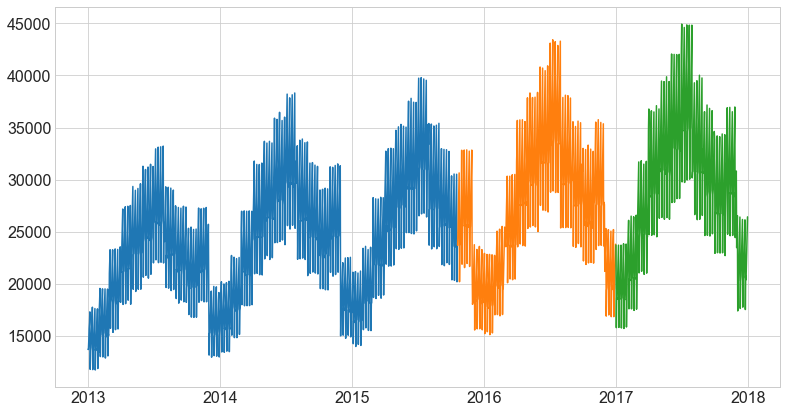

In [4]:
## split train and test ##

#set training size
train_size = .8

#set n (number of observations)
n = df.shape[0]

#mark start of test index
test_index_start = round(train_size * n)

#set train and test
train = df[: test_index_start]
test = df[test_index_start:]

### split train and validate ###

#set training size
train_size = .7

#set n (number of observations)
n = train.shape[0]

#mark start of validate index
validate_index_start = round(train_size * n)

#set validate and then train
validate = train[validate_index_start:]
train = train[: validate_index_start]

#assign new train, validate, test so that there is no day overlap
train = df[:'2015-10-20 00:00:00+00:00']
validate = df['2015-10-21 00:00:00+00:00': '2016-12-31 00:00:00+00:00']
test = df['2017-01-01 00:00:00+00:00':]

#set up plotting data
train_by_day = train.groupby('sale_date').sales.sum().reset_index()
validate_by_day = validate.groupby('sale_date').sales.sum().reset_index()
test_by_night = test.groupby('sale_date').sales.sum().reset_index()

#visualize
plt.plot(train_by_day.sale_date, train_by_day.sales)
plt.plot(validate_by_day.sale_date, validate_by_day.sales)
plt.plot(test_by_night.sale_date, test_by_night.sales)
plt.show();

In [5]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sales          913000 non-null  float64
 1   sale_id        913000 non-null  int64  
 2   item_brand     913000 non-null  object 
 3   item_id        913000 non-null  int64  
 4   item_name      913000 non-null  object 
 5   item_price     913000 non-null  float64
 6   item_upc12     913000 non-null  int64  
 7   item_upc14     913000 non-null  int64  
 8   store_address  913000 non-null  object 
 9   store_city     913000 non-null  object 
 10  store_id       913000 non-null  int64  
 11  store_state    913000 non-null  object 
 12  store_zipcode  913000 non-null  int64  
 13  month          913000 non-null  int64  
 14  day_of_week    913000 non-null  int64  
 15  stringday      913000 non-null  object 
 16  revenue        913000 non-nu

In [6]:
sf.head()

,sales,sale_id,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_id,store_state,store_zipcode,month,day_of_week,stringday,revenue
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,1,1,Tuesday,10.92
2013-01-01 00:00:00+00:00,26.0,295813,Ducal,17,Ducal Refried Red Beans,1.16,88313590791,88313590791,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,1,1,Tuesday,30.16
2013-01-01 00:00:00+00:00,32.0,125995,Twinings Of London,7,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004,8503 NW Military Hwy,San Antonio,10,TX,78231,1,1,Tuesday,308.48
2013-01-01 00:00:00+00:00,45.0,314073,Scotch,18,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,21200725340,21200725340,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,1,1,Tuesday,197.55
2013-01-01 00:00:00+00:00,34.0,332333,Careone,19,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,1,1,Tuesday,25.16


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  1825 non-null   float64
 1   sales    1825 non-null   float64
dtypes: float64(2)
memory usage: 107.3 KB


In [8]:
df.head()

,revenue,sales
sale_date,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0


In [9]:
df[df.index == '2016-02-29 00:00:00+00:00']

,revenue,sales
sale_date,,


In [10]:
df.head(1) == train.head(1)

,revenue,sales
sale_date,,
2013-01-01 00:00:00+00:00,True,True


In [11]:
pd.concat([train.tail(1), validate.head(1)])

,revenue,sales
sale_date,,
2015-10-20 00:00:00+00:00,127872.05,23680.0
2015-10-21 00:00:00+00:00,127315.83,23677.0


In [12]:
pd.concat([validate.tail(1), test.head(1)])

,revenue,sales
sale_date,,
2016-12-31 00:00:00+00:00,128009.31,23792.0
2017-01-01 00:00:00+00:00,127262.71,23709.0


In [13]:
monthly_sample = df.resample('M').sum()

In [14]:
monthly_sample

,revenue,sales
sale_date,,
2013-01-31 00:00:00+00:00,2447368.20,454904.0
2013-02-28 00:00:00+00:00,2469765.97,459417.0
2013-03-31 00:00:00+00:00,3319815.58,617382.0
2013-04-30 00:00:00+00:00,3666901.23,682274.0
2013-05-31 00:00:00+00:00,4102278.40,763242.0
2013-06-30 00:00:00+00:00,4278919.18,795597.0
2013-07-31 00:00:00+00:00,4601659.23,855922.0
2013-08-31 00:00:00+00:00,4125842.31,766761.0
2013-09-30 00:00:00+00:00,3708565.41,689907.0


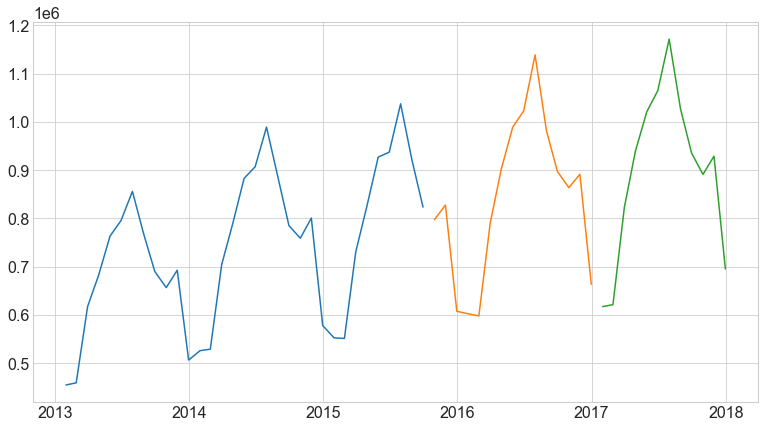

In [15]:
## split train and test ##

#set training size
train_size = .8

#set n (number of observations)
n = monthly_sample.shape[0]

#mark start of test index
test_index_start = round(train_size * n)

#set train and test
train = monthly_sample[: test_index_start]
test = monthly_sample[test_index_start:]

### split train and validate ###

#set training size
train_size = .7

#set n (number of observations)
n = train.shape[0]

#mark start of validate index
validate_index_start = round(train_size * n)

#set validate and then train
validate = train[validate_index_start:]
train = train[: validate_index_start]

#assign new train, validate, test so that there is no day overlap
train = monthly_sample[:'2015-10-20 00:00:00+00:00']
validate = monthly_sample['2015-10-21 00:00:00+00:00': '2016-12-31 00:00:00+00:00']
test = monthly_sample['2017-01-01 00:00:00+00:00':]

#set up plotting data
train_by_day = train.groupby('sale_date').sales.sum().reset_index()
validate_by_day = validate.groupby('sale_date').sales.sum().reset_index()
test_by_night = test.groupby('sale_date').sales.sum().reset_index()

#visualize
plt.plot(train_by_day.sale_date, train_by_day.sales)
plt.plot(validate_by_day.sale_date, validate_by_day.sales)
plt.plot(test_by_night.sale_date, test_by_night.sales)
plt.show();

In [16]:
monthly_sample.head(1) == train.head(1)

,revenue,sales
sale_date,,
2013-01-31 00:00:00+00:00,True,True


In [17]:
pd.concat([train.tail(3), validate.head(3)])

,revenue,sales
sale_date,,
2015-07-31 00:00:00+00:00,5575319.12,1037350.0
2015-08-31 00:00:00+00:00,4951252.98,920401.0
2015-09-30 00:00:00+00:00,4426326.24,823332.0
2015-10-31 00:00:00+00:00,4286868.40,797253.0
2015-11-30 00:00:00+00:00,4448745.67,827645.0
2015-12-31 00:00:00+00:00,3268736.22,607572.0


In [18]:
pd.concat([validate.tail(1), test.head(1)])

,revenue,sales
sale_date,,
2016-12-31 00:00:00+00:00,3563185.99,663411.0
2017-01-31 00:00:00+00:00,3319300.40,617306.0


In [19]:
## copy-paste ##

def evaluate(target_var):
    rmse = round((mean_squared_error(validate[target_var], y_hat[target_var])) ** (1/2), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(y_hat[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Exercise II

Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
* Simple Average
* Moving Average
* Holt's Linear Trend Model
* Based on previous year/month/etc., this is up to you.

### Last Observed Value

In [20]:
items = train['sales'][-1:][0]
dollars = round(train['revenue'][-1:][0], 2)

y_hat = pd.DataFrame({'sales': items,
                      'revenue': dollars},
                     index = validate.index
                    )

y_hat.head()

,sales,revenue
sale_date,,
2015-10-31 00:00:00+00:00,823332.0,4426326.24
2015-11-30 00:00:00+00:00,823332.0,4426326.24
2015-12-31 00:00:00+00:00,823332.0,4426326.24
2016-01-31 00:00:00+00:00,823332.0,4426326.24
2016-02-29 00:00:00+00:00,823332.0,4426326.24


revenue -- RMSE: 858711


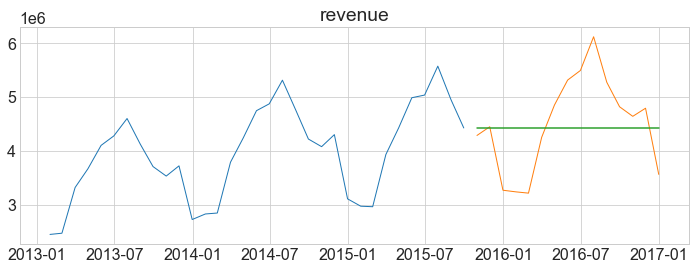

sales -- RMSE: 159760


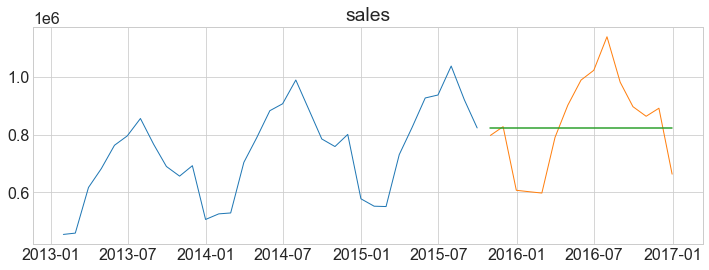

In [21]:
for cat in train.columns:
    plot_and_eval(cat)

### Simple Average

In [22]:
sales = round(train.sales.mean(), 2)
revenue = round(train.revenue.mean(), 2)

def make_predictions():
    y_hat = pd.DataFrame({'sales': sales,
                          'revenue': revenue},
                         index = validate.index
                        )
    return y_hat

y_hat = make_predictions()
y_hat.head()

,sales,revenue
sale_date,,
2015-10-31 00:00:00+00:00,738822.48,3972260.86
2015-11-30 00:00:00+00:00,738822.48,3972260.86
2015-12-31 00:00:00+00:00,738822.48,3972260.86
2016-01-31 00:00:00+00:00,738822.48,3972260.86
2016-02-29 00:00:00+00:00,738822.48,3972260.86


revenue -- RMSE: 1007868


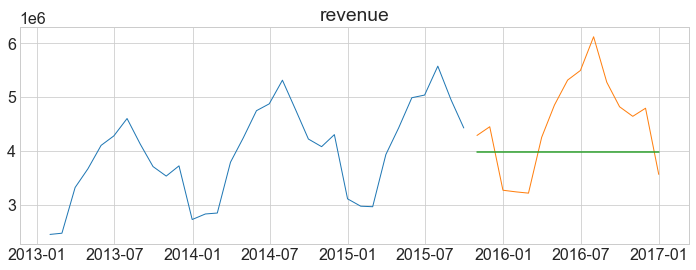

sales -- RMSE: 187550


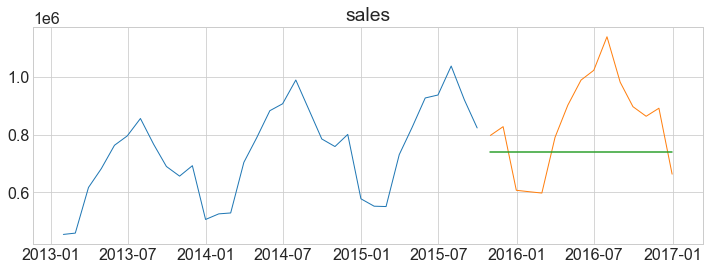

In [23]:
for cat in train.columns:
    plot_and_eval(cat)

In [24]:
for cat in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = cat)

In [25]:
eval_df.rmse = eval_df.rmse.apply(lambda x: int(x))

In [26]:
eval_df['read_rmse'] = eval_df.rmse.apply(mf.add_commas)

In [27]:
eval_df

,model_type,target_var,rmse,read_rmse
0,simple_average,revenue,1007868,"1,007,868"
1,simple_average,sales,187550,"187,550"
